In [1]:
import pathlib
import random
import tensorflow as tf
tf.enable_eager_execution()
# ================ DATASET INFORMATION ======================
# State dataset directory where the tfrecord files are located
dataset_dir = '/Users/hchan/Downloads/CASIA-FaceV5-Crop'

# State where your log file is at. If it doesn't exist, create it.
log_dir = './log'

# State where your checkpoint file is
checkpoint_file = './inception_resnet_v2_2016_08_30.ckpt'

data_root = pathlib.Path(dataset_dir)

print("The dataset path is :", data_root)

# for dir in data_root.iterdir():
#     print(dir)


piclist = list(data_root.glob('*/*'))
random.shuffle(piclist)
piclist_str = list(map(str,piclist))
print("Total image size:",len(piclist))




The dataset path is : /Users/hchan/Downloads/CASIA-FaceV5-Crop
Total image size: 2515


显示几幅图片

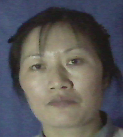

In [2]:
import IPython.display as display
from PIL import Image

pic = Image.open(str(piclist[0]))

display.display(pic)

In [3]:
# 生成图片label

label_list = [int(pic_path.parent.name) for pic_path in piclist]

label_list[:10]

[161, 220, 242, 350, 403, 292, 391, 114, 196, 358]

In [4]:
# read image, resize to 299*299 and scale each pixel to [-1,1];
def image_preprocess(piclist_str):
    img_raw = tf.io.read_file(piclist_str)
#     print(repr(img_raw)[:100])

    img_tensor = tf.image.decode_bmp(img_raw,channels=3)
#     print(img_tensor.shape)
#     print(img_tensor.dtype)
    img_final = tf.image.resize(img_tensor, [299, 299])
    img_final = img_final/127.5 - 1

#     print(img_final.shape)
#     print(img_final.numpy().min())
#     print(img_final.numpy().max())
    return img_final

# image_preprocess(piclist_str[0])


In [5]:
# 构建Dataset

path_ds = tf.data.Dataset.from_tensor_slices(piclist_str)
image_ds = path_ds.map(image_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)


In [6]:
# review tf dataset
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
for n,image in enumerate(image_ds.take(4)):
  plt.subplot(2,2,n+1)
  plt.imshow(image)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.xlabel(label_list[n])

Instructions for updating:
Colocations handled automatically by placer.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [7]:
label_ds = tf.data.Dataset.from_tensor_slices(label_list)
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))

In [8]:
image_label_ds=image_label_ds.repeat()
image_label_ds=image_label_ds.shuffle(buffer_size=25)
# image_label_ds=image_label_ds.batch(32)

irv2 = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=False)
irv2.trainable=False

In [9]:
# irv2.fit(image_ds.take(2))

import numpy as np

p1_tensors = next(iter(image_ds)) #.take(1).make_one_shot_iterator())

x = np.expand_dims(p1_tensors, axis=0)

# irv2.fit(p1_tensor[0])
result = irv2.predict(x)


In [11]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# This returns a tensor
input1 = Input(shape=(299,299,3))
input2 = Input(shape=(299,299,3))

out1 = irv2(input1)
out2 = irv2(input2)

